# **ENTREGABLE - Personal**

+ Magno Ricado Luque Mamani

El presente Jupyter Notebook es el desarrollo en el uso de Redes Neuronales Convolucionales para la clasificación de imágenes de perros y gatos.

# Tabla de contenido
1. Funciones de utilidad
2. Construcción de una red neuronal convolucional
  - Definición del modelo
  - Generador de datos
  - Formación
  - Aumento de datos
3. Visualización de mapas de características

In [1]:
# Importamos las librería necesarias
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import pickle
import tensorflow as tf

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
from keras import backend as K

In [2]:
# Instalamos kaggle para la descarga de los dataset
!pip install kaggle

In [4]:
# Usaremos el token de la API de kaggle
kaggle_username = 'b'
kaggle_key = '07a0cbf210bcd'

# Configuramos las variables de entorno para Kaggle
os.environ['KAGGLE_USERNAME'] = kaggle_username
os.environ['KAGGLE_KEY'] = kaggle_key

In [5]:
# Comprobamos que se conecte con la API de kaggle
!kaggle datasets list

ref                                                                  title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
haseebindata/student-performance-predictions                         Student Performance Predictions                  9KB  2024-08-17 06:57:57           5185        114  0.9411765        
uom190346a/sleep-and-health-metrics                                  Sleep and Health Metrics                        73KB  2024-08-31 02:39:09            851         26  1.0              
berkayalan/paris-2024-olympics-medals                                Paris 2024 Olympics Medals                       1KB  2024-08-14 11:02:45           4836         90  1.0              
jeannicolasduval/2024-fortune-1000-companies                

In [6]:
# Importamos kaggle
import kaggle

# Definimos el nombre del dataset desde kaggle para descargar las imágenes
# de entrenamiento y prueba
dataset_perros_gatos = 'samuelcortinhas/cats-and-dogs-image-classification'

# Definimos el directorio de destino
destination_dir = '/content/dataset'

# Creamos el directorio si no existe
os.makedirs(destination_dir)

# Descargamos el dataset completo delas imágenes
kaggle.api.dataset_download_files(dataset_perros_gatos, path=destination_dir, unzip=True)

print(f'Dataset descargado y descomprimido en {destination_dir}')

Dataset URL: https://www.kaggle.com/datasets/samuelcortinhas/cats-and-dogs-image-classification
Dataset descargado y descomprimido en /content/dataset


In [7]:
# Definimos el nombre del dataset de imágenes de validación desde kaggle
dataset_perros_gatos_validacion = 'mattop/ai-cat-and-dog-images-dalle-mini'

# Definimos el directorio de destino
destination_dir = '/content/dataset/validation'

# Creamos el directorio si no existe
os.makedirs(destination_dir)

# Descargamos el dataset completo de las imágenes de validación
kaggle.api.dataset_download_files(dataset_perros_gatos_validacion, path=destination_dir, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/mattop/ai-cat-and-dog-images-dalle-mini


# **1. Funciones de utilidad**


In [22]:
# Las siguientes funciones fueron declaradas para la visualización de gráficas del comportamiendo del modelo de CNN
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['accuracy'])
    acc = smooth_curve(history.history['accuracy'][:steps])
    val_acc = smooth_curve(history.history['val_accuracy'][:steps])
    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])

    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()

    plt.figure(figsize=(6, 4))
    plt.plot(acc, c='#0c7cba', label='Train Acc')
    plt.plot(val_acc, c='#0f9d58', label='Val Acc')
    plt.xticks(range(0, len(acc), 5))
    plt.xlim(0, len(acc))
    plt.title('Train Accuracy: %.3f, Val Accuracy: %.3f' % (acc[-1], val_acc[-1]), fontsize=12)
    plt.legend()

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

def load_history(fn):
    with open(fn, 'rb') as fr:
        history = pickle.load(fr)
    return history

def jitter(img, amount=32):
    ox, oy = np.random.randint(-amount, amount+1, 2)
    return np.roll(np.roll(img, ox, -1), oy, -2), ox, oy

def reverse_jitter(img, ox, oy):
    return np.roll(np.roll(img, -ox, -1), -oy, -2)

def plot_image(img):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

# **2. Construcción de una red neuronal convolucional**

## **2.1 Definición del modelo**

In [9]:
# Definimos el modelo
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1', input_shape=(150, 150, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2), name='maxpool_1'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model.add(tf.keras.layers.MaxPooling2D((2, 2), name='maxpool_2'))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model.add(tf.keras.layers.MaxPooling2D((2, 2), name='maxpool_3'))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model.add(tf.keras.layers.MaxPooling2D((2, 2), name='maxpool_4'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(512, activation='relu', name='dense_1'))
model.add(tf.keras.layers.Dense(256, activation='relu', name='dense_2'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid', name='output'))

# Compilamos el modelo con el optimizador 'adam', con la función de perdida 'binary_crissentropy' con el 'accuracy' como métrica
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## **2.2 Generador de datos**

In [10]:
# Declaramos las rutas donde se encuentran nuestros datasets de imágenes de entrenamiento, validación y prueba
base_dir = '/content/dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation/DogsCats')
test_dir = os.path.join(base_dir, 'test')

# Definimos el preprocesamiento
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 557 images belonging to 2 classes.
Found 108 images belonging to 2 classes.


## **2.3 Formación**

In [11]:
# Pasamos a la etapa de entrenamiento del modelo
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=20,
                    validation_data=validation_generator,
                    validation_steps=50, verbose=1)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.4999 - loss: 0.7275 - val_accuracy: 0.5000 - val_loss: 0.6924
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5076 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6915
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.5224 - loss: 0.6919 - val_accuracy: 0.5833 - val_loss: 0.6876
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5468 - loss: 0.6847 - val_accuracy: 0.7315 - val_loss: 0.6477
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5675 - loss: 0.6812 - val_accuracy: 0.5185 - val_loss: 0.6516
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5862 - loss: 0.6691 - val_accuracy: 0.6759 - val_loss: 0.5648
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6234 - loss: 0.6466 - val_accuracy: 0.7685 - val_loss: 0.6455
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6620 - loss: 0.6303 - val_acc

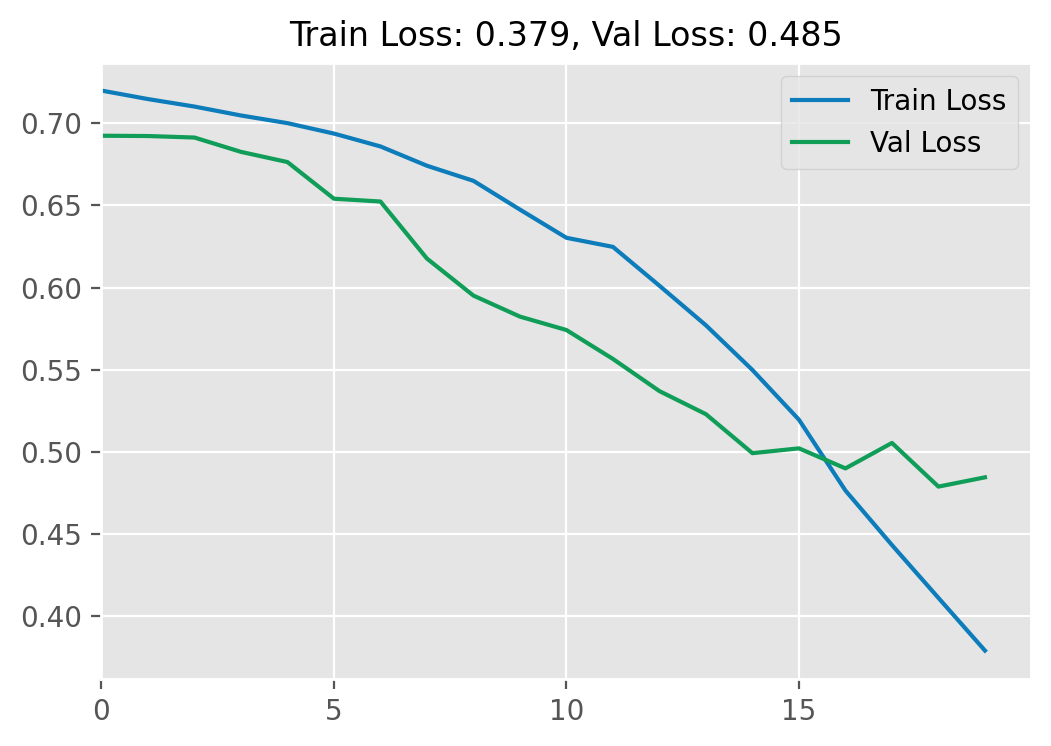

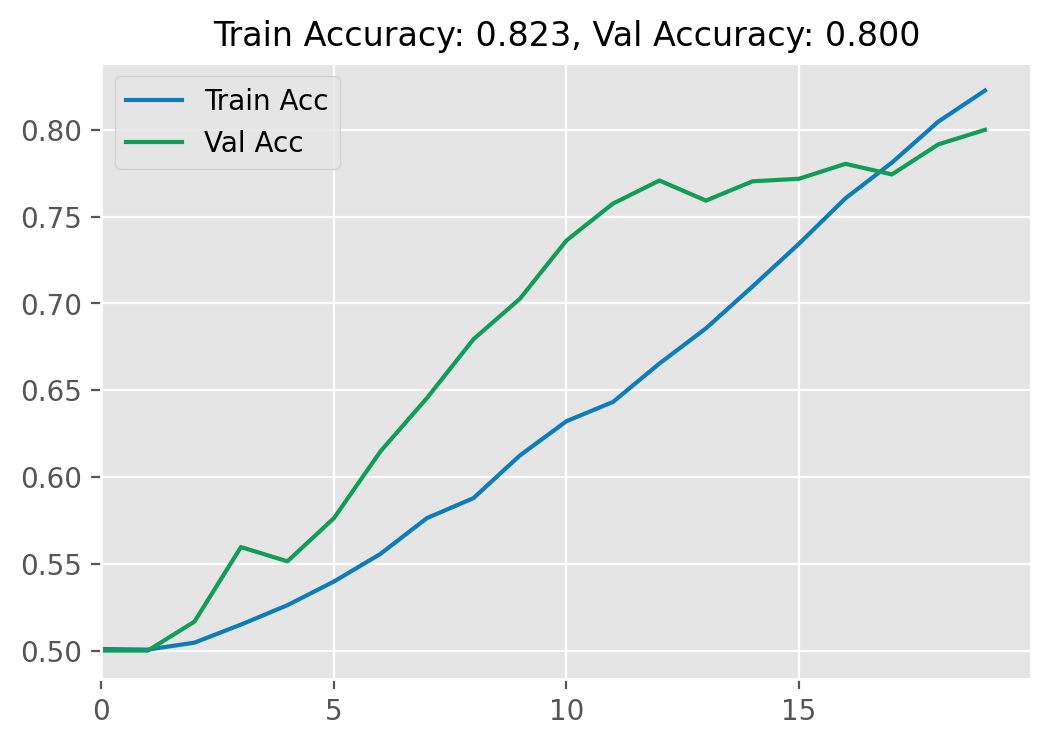

In [12]:
# Mostramos el registro de nuestro modelo después de ser entrenado
plot_compare(history)

## **2.4 Aumento de datos**

In [13]:
model_aug = tf.keras.models.Sequential()
model_aug.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1', input_shape=(150, 150, 3)))
model_aug.add(tf.keras.layers.MaxPooling2D((2, 2), name='maxpool_1'))
model_aug.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model_aug.add(tf.keras.layers.MaxPooling2D((2, 2), name='maxpool_2'))
model_aug.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model_aug.add(tf.keras.layers.MaxPooling2D((2, 2), name='maxpool_3'))
model_aug.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model_aug.add(tf.keras.layers.MaxPooling2D((2, 2), name='maxpool_4'))
model_aug.add(tf.keras.layers.Flatten())
model_aug.add(tf.keras.layers.Dropout(0.5))
model_aug.add(tf.keras.layers.Dense(512, activation='relu', name='dense_1'))
model_aug.add(tf.keras.layers.Dense(256, activation='relu', name='dense_2'))
model_aug.add(tf.keras.layers.Dense(1, activation='sigmoid', name='output'))

In [14]:
model_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
# Realizamos el aumento de datos de imágenes, como rotando, haciendolo ancho, ...
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Se consideró que los datos de validación no deben aumentarse
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

# Procedemos a entrenarlo
history_aug = model_aug.fit(train_generator,
                            steps_per_epoch=100,
                            epochs=100,
                            validation_data=validation_generator,
                            validation_steps=50,
                            verbose=1)

Found 557 images belonging to 2 classes.
Found 108 images belonging to 2 classes.
Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.5269 - loss: 0.6950 - val_accuracy: 0.5000 - val_loss: 0.6992
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.4892 - loss: 0.6960 - val_accuracy: 0.5185 - val_loss: 0.6924
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5518 - loss: 0.6879 - val_accuracy: 0.7593 - val_loss: 0.6448
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.5441 - loss: 0.6869 - val_accuracy: 0.5278 - val_loss: 0.6342
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.6237 - loss: 0.6716 - val_accuracy: 0.7685 - val_loss: 0.5517
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.5757 - loss: 0.6818 - val_accuracy: 0.7407 - val_loss: 0.5835
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.5878 - loss: 0.6719 - val_accuracy: 0.5648 - val_loss: 0.6284
Epoch 

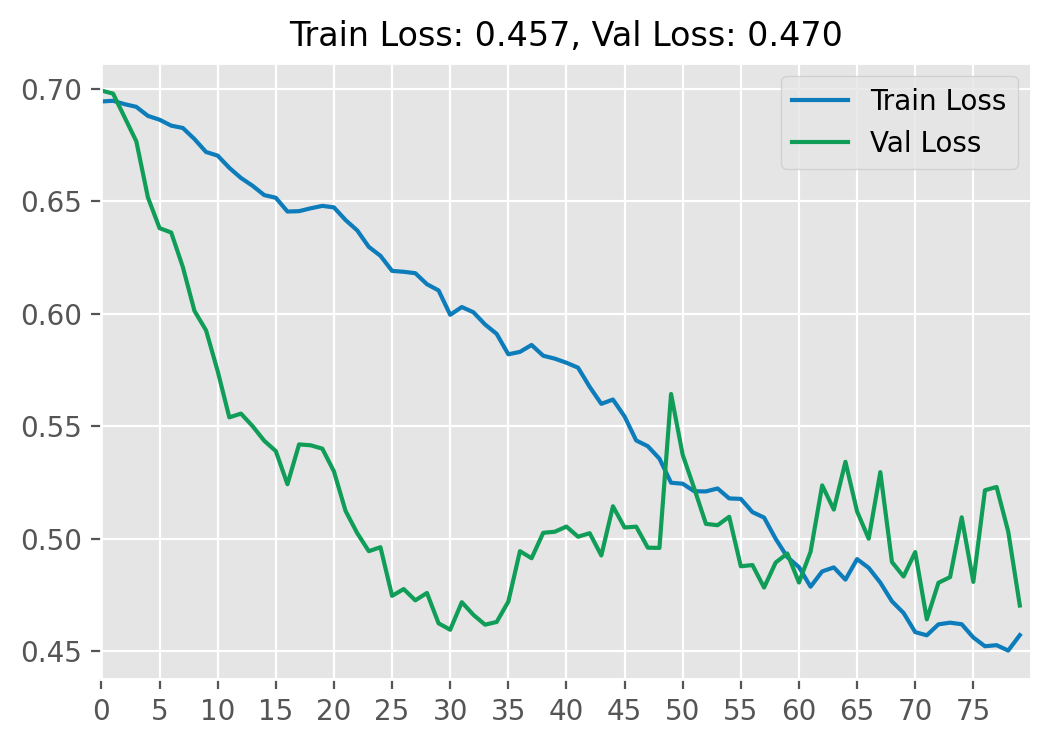

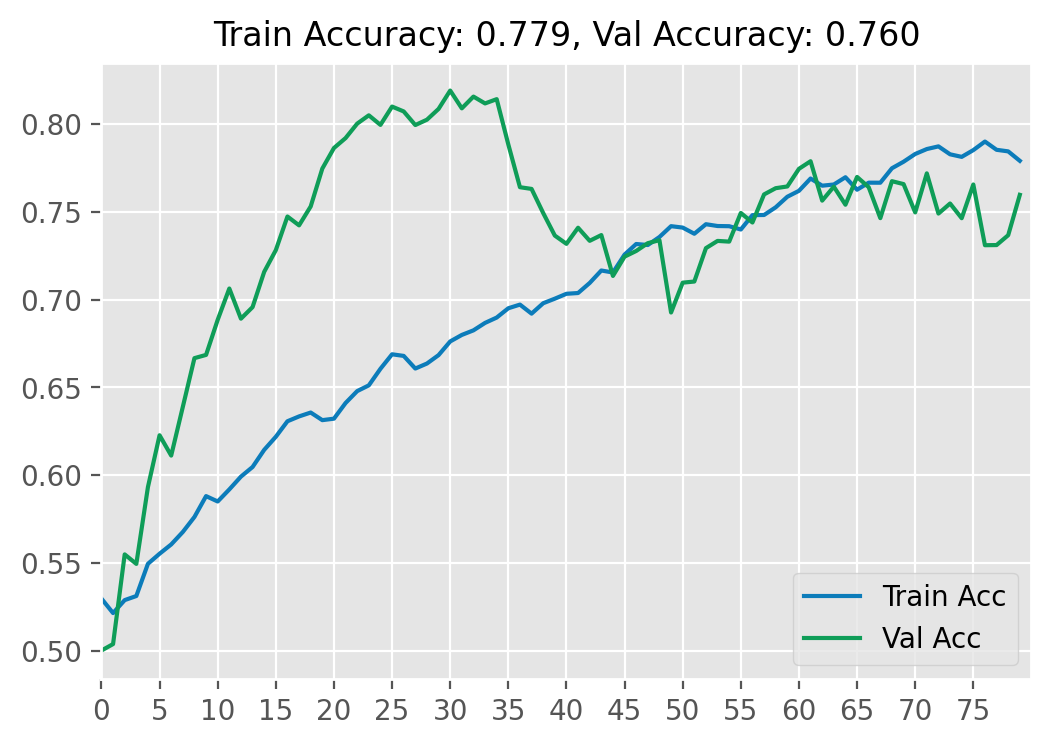

In [17]:
# Se muestra la mejora del modelo
plot_compare(history_aug, steps=80)

In [18]:
# Descargamos el modelo entredado
model_aug.save('model_aug.h5')
# Podemos guardar el registro del entrenamiento del modelo
save_history(history_aug, 'history_aug.bin')

In [31]:
# Mostramos el histograma del modelo
history_aug = load_history('history_aug.bin')
history_aug.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

# **3. Visualización de mapas de características**

In [50]:
# Definimos a nuestra función para tratar con tensores

def imagen_tensor(ruta_imagen):
  img = tf.keras.preprocessing.image.load_img(ruta_imagen, target_size=(150, 150))
  img_tensor = tf.keras.preprocessing.image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.

  return img_tensor

In [51]:
imagen_ruta1 = '/content/dataset/train/cats/cat_102.jpg'
imagen_tensor1 = imagen_tensor(imagen_ruta1)
print(imagen_tensor1.shape)

(1, 150, 150, 3)


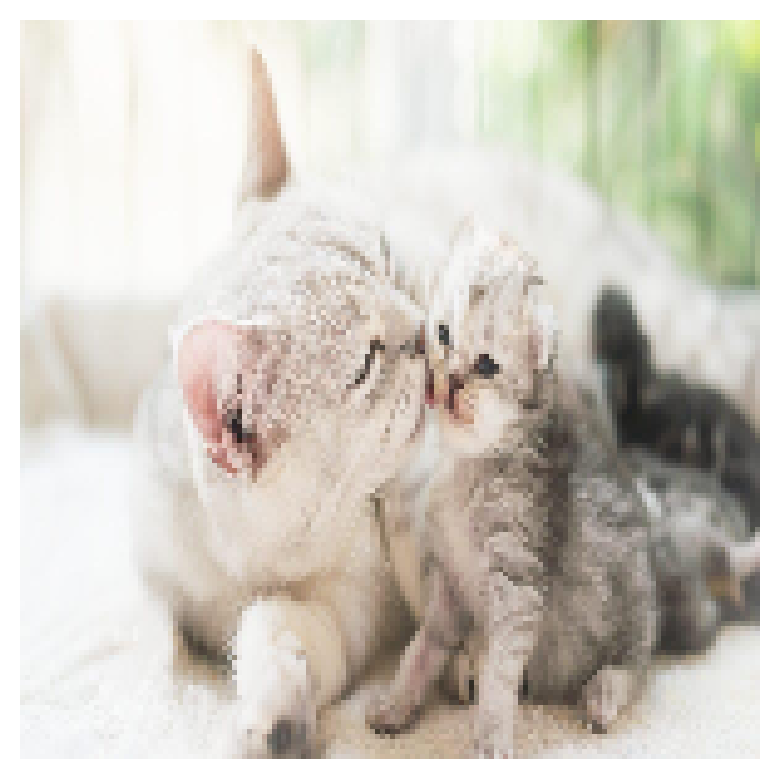

In [48]:
plt.imshow(imagen_tensor1[0])
plt.axis('off')
plt.show()

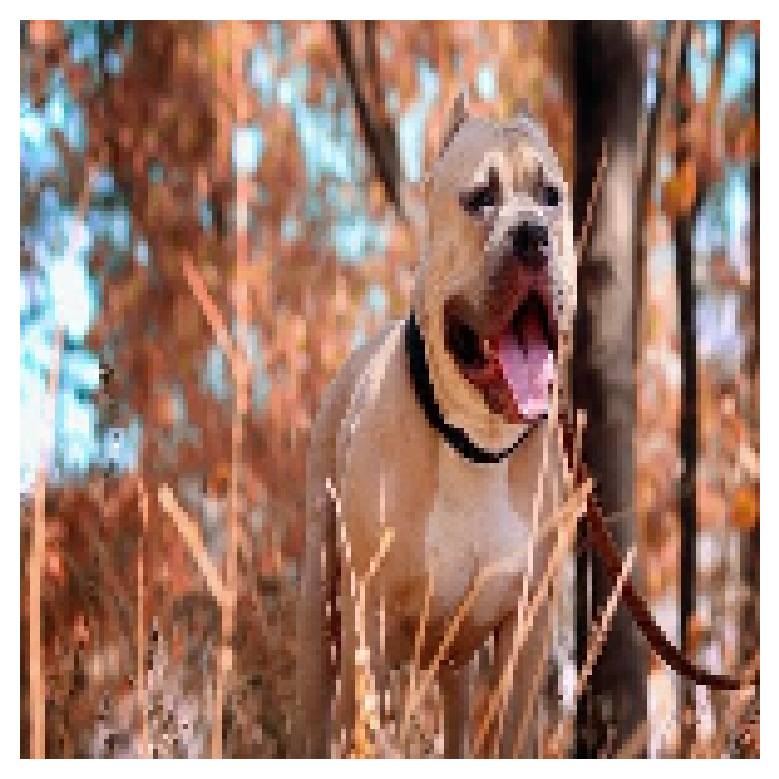

In [52]:
imagen_ruta2 = '/content/dataset/train/dogs/dog_129.jpg'
imagen_tensor2 = imagen_tensor(imagen_ruta2)
plt.imshow(imagen_tensor2[0])
plt.axis('off')
plt.show()

In [55]:
# Definimos la función usando nuestro modelo entrenado

def predecir(imagen):
  prediccion = model_aug.predict(imagen)
  if prediccion[0] < 0.5:
    print("Esta imagen pertenece a la clase de gatos")
  else:
    print("Esta imagen pertenece a la clase de perros")

In [56]:
# Pondremos a prueba nuestro modelo con la imagen de un gato
predecir(imagen_tensor1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Esta imagen pertenece a la clase de gatos


In [58]:
# Pondremos a prueba nuestro modelo con la imagen de un perro
predecir(imagen_tensor2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Esta imagen pertenece a la clase de perros


In [ ]:
# Se puede observar que para valore inferiores a 0.5 se trata de imágenes de gatos, lo que hace
# que a valores mayores a este se trate de perros.

In [ ]:
###################################################

USAMOS LA RED CONVOLUCIONAL PRENETRENADA VGG16, PARA VISUALIZAR LA EXTRACCIÓN DE CARACTERÍSTICAS DE LA IMAGEN

In [ ]:
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False)
vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


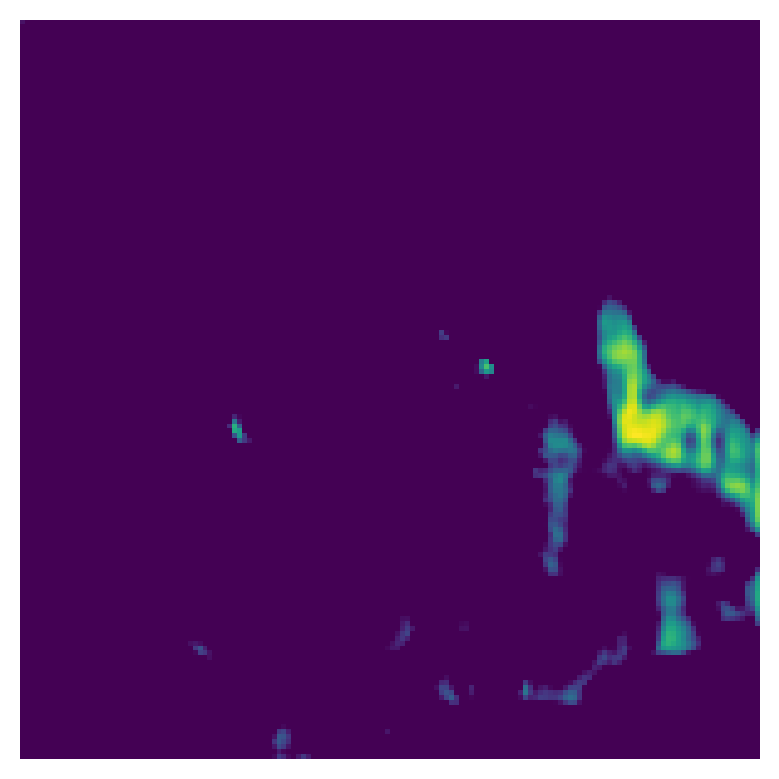

In [ ]:
# Extrae las salidas de las 8 capas superiores:
layer_outputs = [layer.output for layer in vgg.layers if 'conv1' in layer.name]
activation_model = tf.keras.models.Model(inputs=vgg.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

first_layer_activation = intermediate_activations[0]

plt.imshow(first_layer_activation[0, :, :, 19], cmap='viridis')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


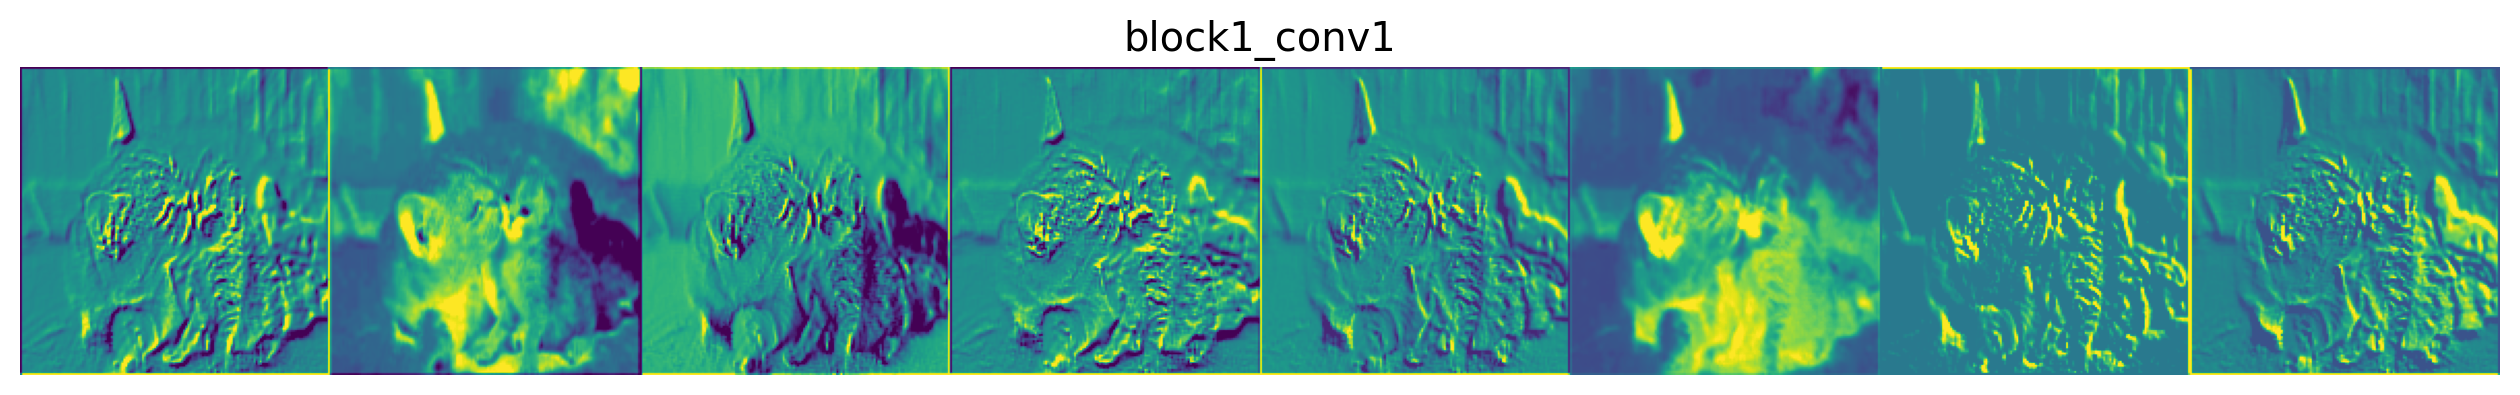

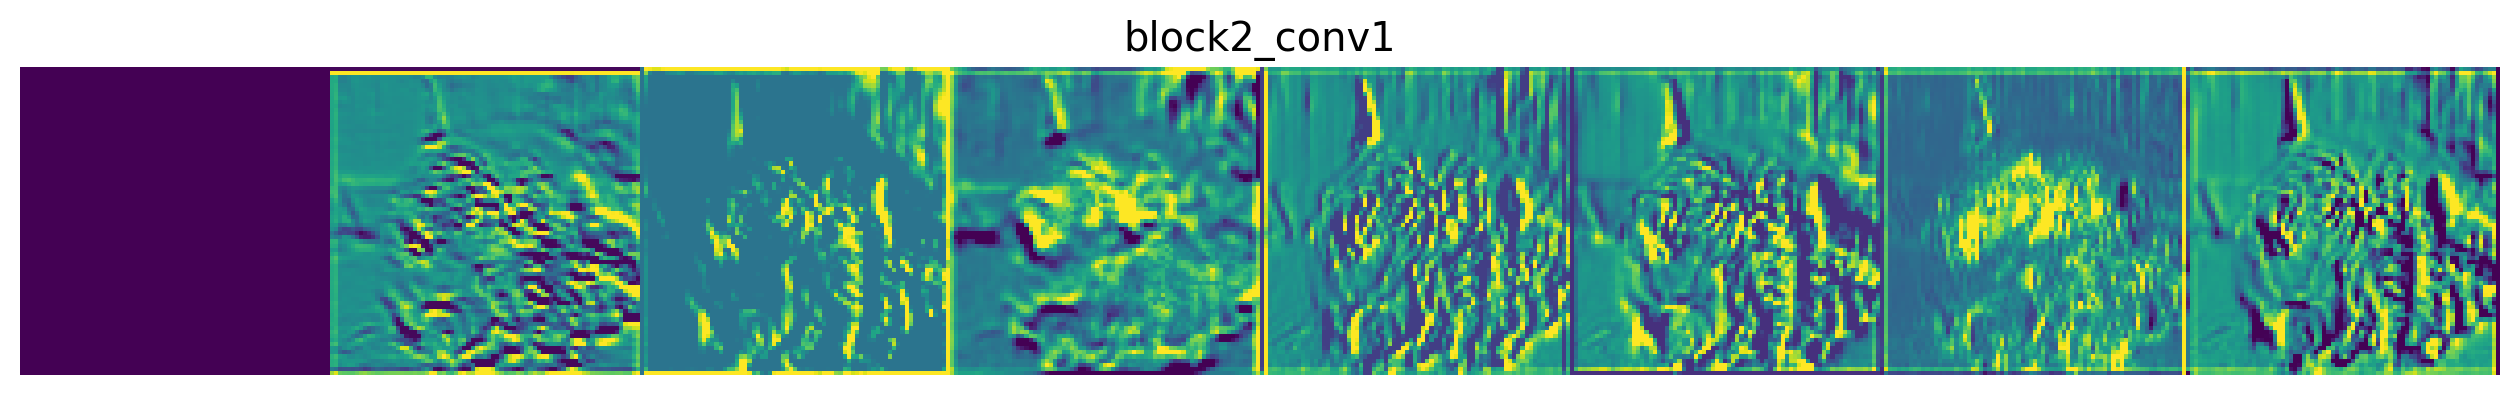

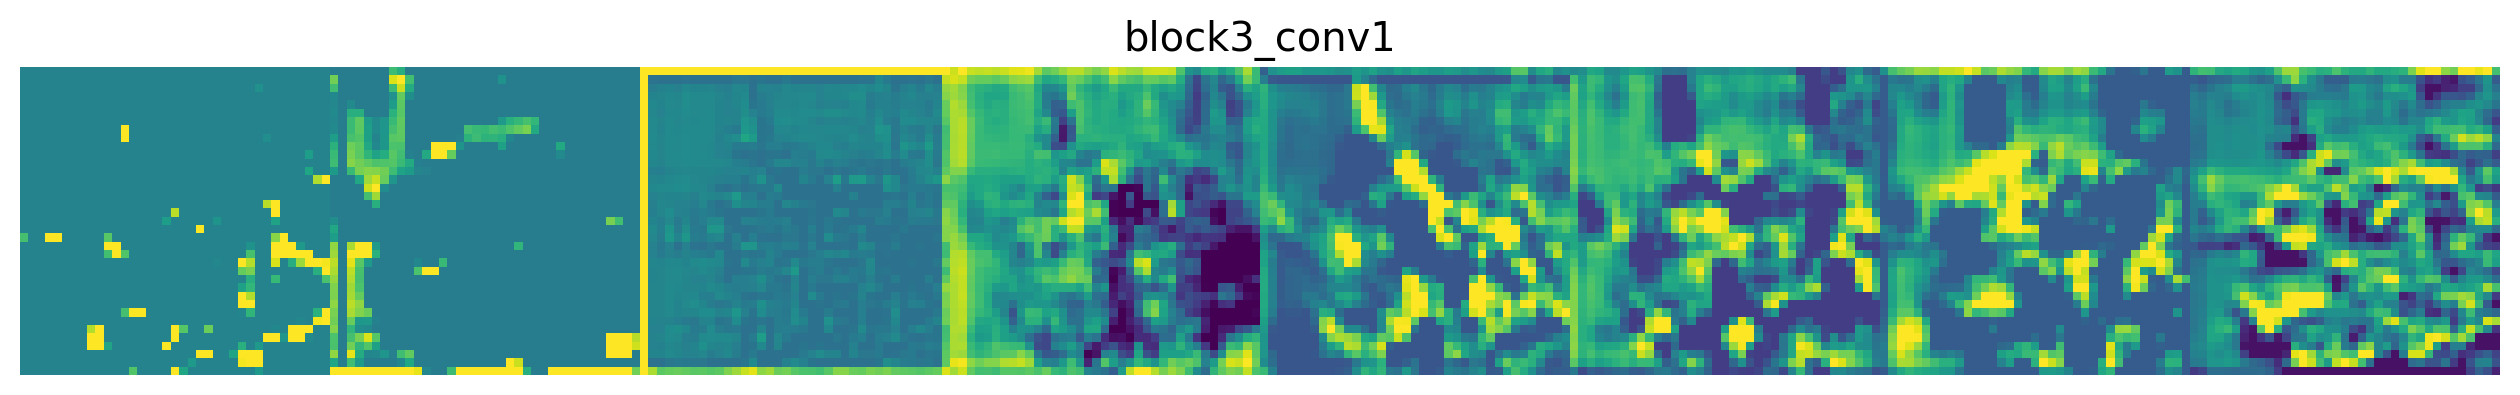

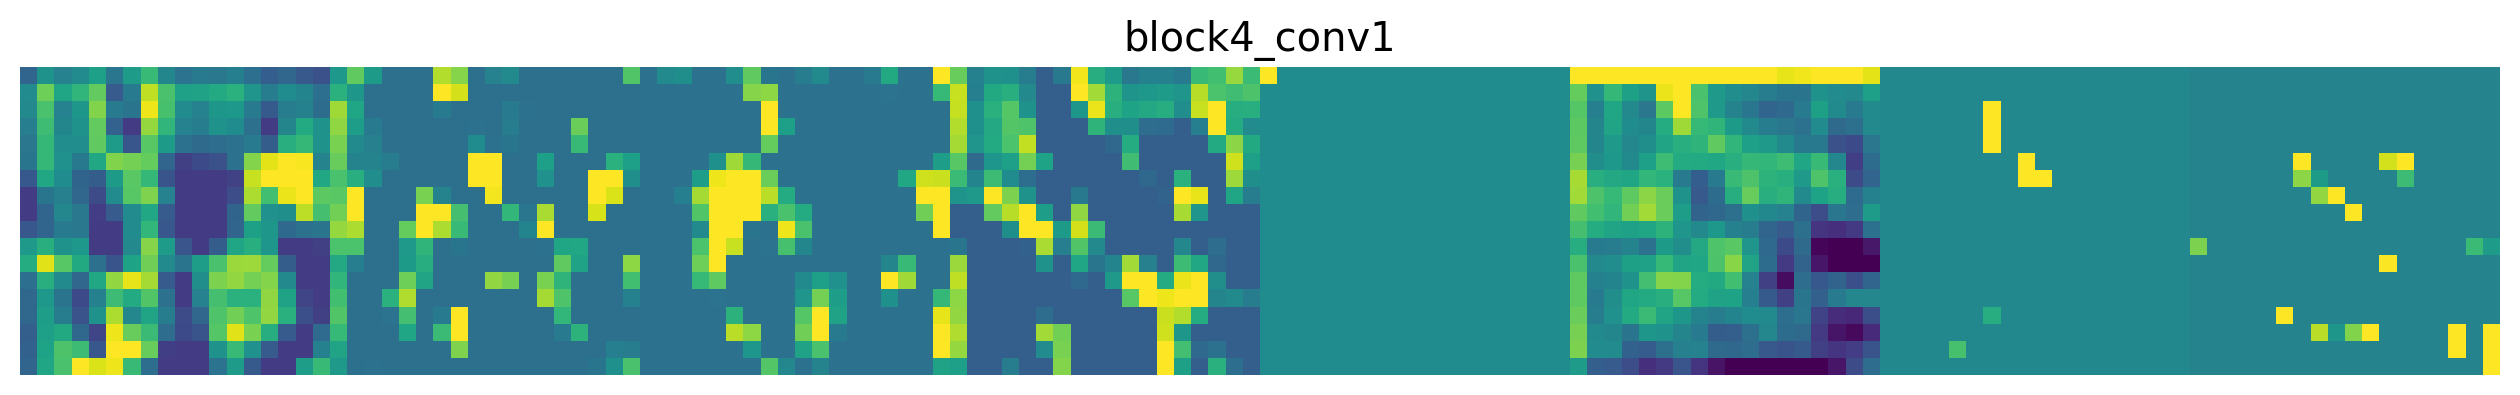

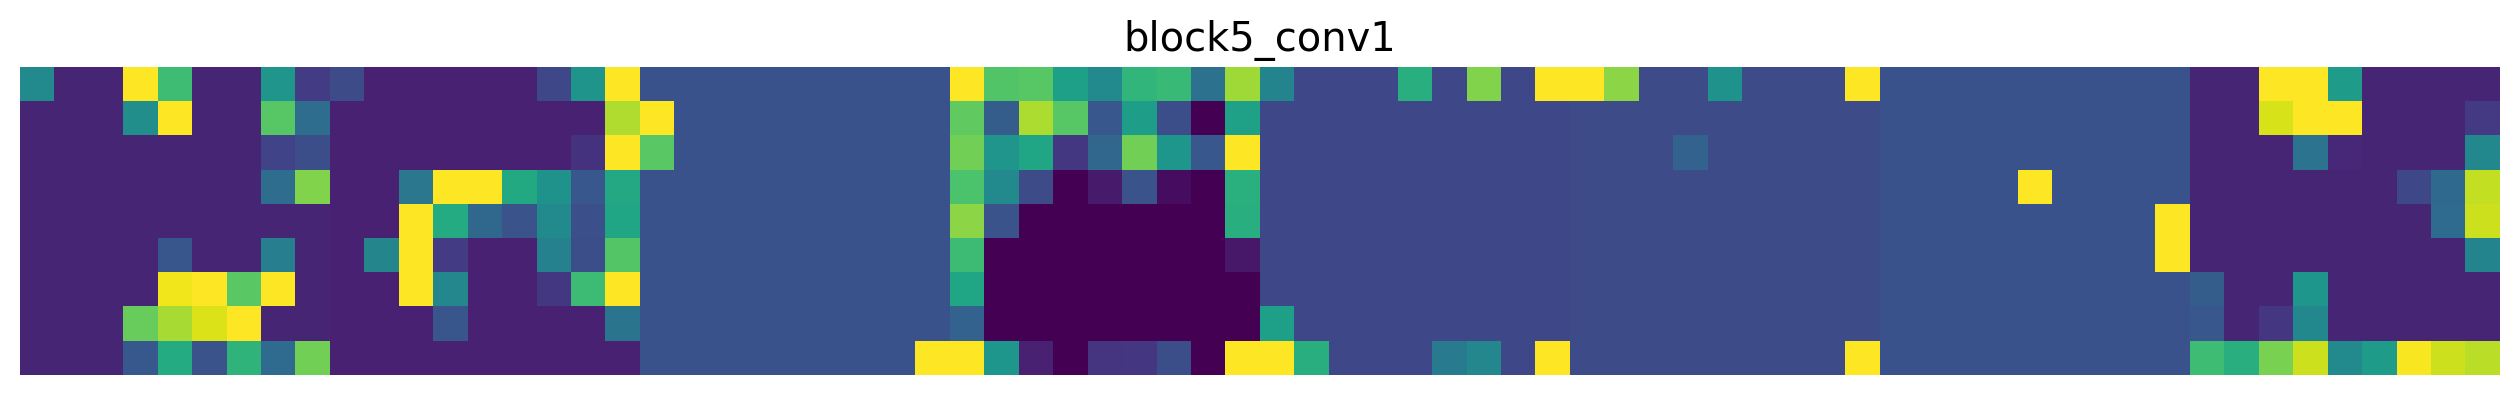

In [ ]:
layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

layer_outputs = [layer.output for layer in vgg.layers if layer.name in layer_names]
activation_model = tf.keras.models.Model(inputs=vgg.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

images_per_row = 8
max_images = 8
# Ahora mostremos nuestros mapas de características.
for layer_name, layer_activation in zip(layer_names, intermediate_activations):

    n_features = layer_activation.shape[-1]
    n_features = min(n_features, max_images)

    size = layer_activation.shape[1]

    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]

            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # # Mostrar la cuadrícula
    scale = 2. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.axis('off')
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()